In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_excel('Assignment1_Climate_Crop_Data.xlsx')

In [3]:
df

,District,Year,Month,Avg_Temperature_C,Rainfall_mm,Crop_Yield_t_per_ha
0,Pune,2019,Jan,18.99,18.62,NaN
1,Pune,2019,Feb,19.30,35.23,NaN
2,Pune,2019,Mar,31.30,17.66,NaN
3,Pune,2019,Apr,36.74,27.67,NaN
4,Pune,2019,May,30.59,25.43,NaN
...,...,...,...,...,...,...
1195,Dehradun,2023,Aug,28.59,268.28,NaN
1196,Dehradun,2023,Sep,26.43,245.47,NaN
1197,Dehradun,2023,Oct,22.17,75.05,NaN
1198,Dehradun,2023,Nov,23.87,78.53,NaN


The data types of columns are consistent with the values presesnt in the dataframe. So, there is no need to change the data types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   District             1200 non-null   object 
 1   Year                 1200 non-null   int64  
 2   Month                1200 non-null   object 
 3   Avg_Temperature_C    1200 non-null   float64
 4   Rainfall_mm          1200 non-null   float64
 5   Crop_Yield_t_per_ha  40 non-null     float64
dtypes: float64(3), int64(1), object(2)
memory usage: 56.4+ KB


From below analysis we can see that the there are only 40 non null values in crop yeild column (out of 1200 data points).

In [5]:
df.describe()

,Year,Avg_Temperature_C,Rainfall_mm,Crop_Yield_t_per_ha
count,1200.000000,1200.000000,1200.000000,40.000000
mean,2021.000000,25.837375,119.980383,3.386500
std,1.414803,5.612888,120.857513,0.636036
min,2019.000000,11.520000,-9.400000,2.510000
25%,2020.000000,21.095000,20.927500,2.810000
50%,2021.000000,26.625000,42.315000,3.205000
75%,2022.000000,29.842500,247.362500,4.060000
max,2023.000000,40.200000,403.160000,4.480000


In [6]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

C:\Users\Ganesh Valtule\AppData\Local\Temp\ipykernel_30824\2097250653.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg = df.groupby('Month')['Avg_Temperature_C'].mean().reset_index()


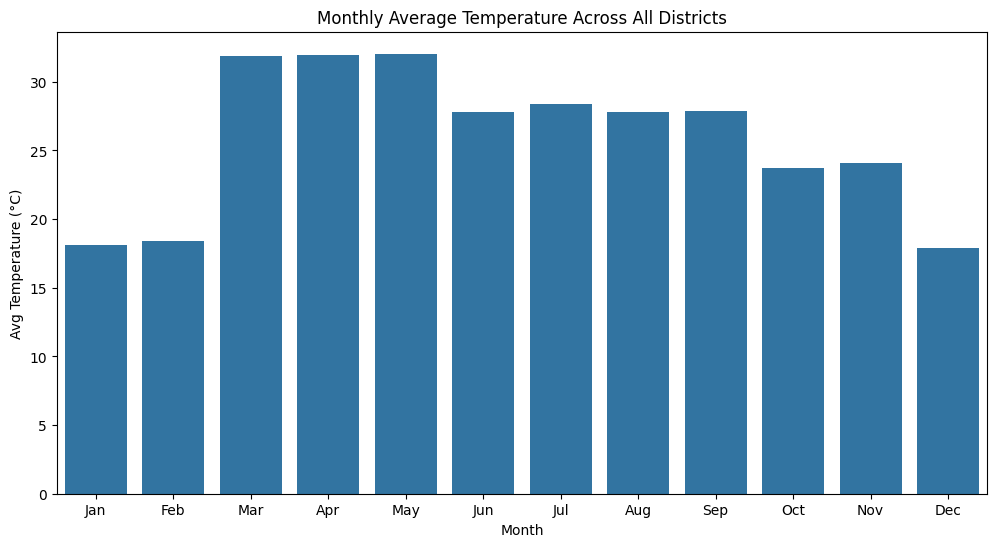

In [ ]:
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

df_avg = df.groupby('Month')['Avg_Temperature_C'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=df_avg, x='Month', y='Avg_Temperature_C')
plt.title("Monthly Average Temperature Across All Districts")
plt.ylabel("Avg Temperature (°C)")
plt.show()

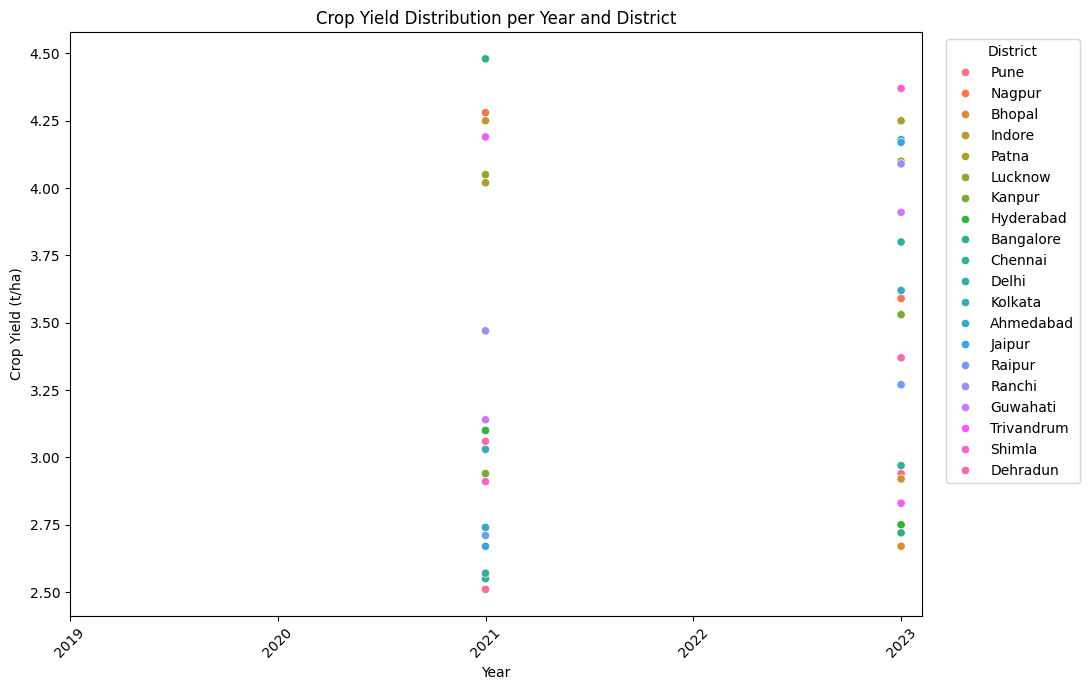

In [8]:

df['Year'] = pd.Categorical(df['Year'], ordered=True, categories=sorted(df['Year'].unique()))

plt.figure(figsize=(11,7))
sns.scatterplot(data=df, x='Year', y='Crop_Yield_t_per_ha', hue='District')
plt.title("Crop Yield Distribution per Year and District")

plt.xticks(ticks=[2019,2020,2021,2022,2023], rotation=45)

plt.ylabel("Crop Yield (t/ha)")
plt.xlabel("Year")
plt.legend(title='District', bbox_to_anchor=(1.02, 1), loc='best')
plt.tight_layout()
plt.show()


From above figure we can see that, the crop values are only available for 2021 and 2023 ranging from approximately 2.5 to 4.5

<Axes: xlabel='Crop_Yield_t_per_ha', ylabel='Count'>

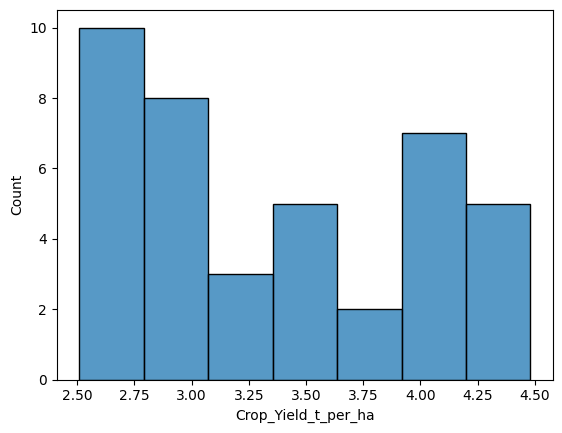

In [9]:
sns.histplot(df['Crop_Yield_t_per_ha'])

This is the distribution of Crop_Yield_t_per_ha values

<Axes: >

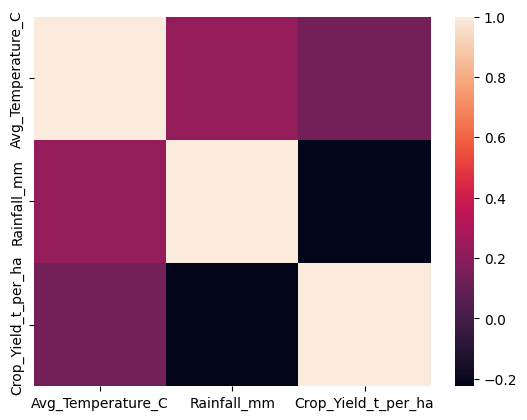

In [10]:
sns.heatmap(df.corr(numeric_only=True))

Data is for 20 different districts

In [11]:
len(df['District'].unique())

20

Considering the wheat crop yield for analysis


# Approach 1

- In india the wheat crop season is around the winter and start of summer
- sowing in Nov-dec-jan and harvesting in feb-mar
- So the taking the months Nov, Dec, Jan, Feb and Mar for analysis.

In [12]:
filtered_df_1 = df[df['Month'].isin(['Nov','Dec','Jan','Feb','Mar'])]

- I will create a ‘season year’ column that groups November and December of the previous year together with January, February, and March of the current year. 
- For example, the 2020 wheat season will include November and December 2019, along with January to March 2020.

In [13]:
def assign_season_year(row):
    try:
        if row['Month'] == 'Dec':
            return int(row['Year'] + 1)
        else:
            return int(row['Year'])
    except Exception:
        return None 

In [ ]:
filtered_df_1 = filtered_df_1.copy()
filtered_df_1['season_year'] = filtered_df_1.apply(assign_season_year, axis=1)

In [15]:
filtered_df_1 = filtered_df_1[filtered_df_1['season_year'].isin(df['Year'].unique())]

- Next, we will check which values in the dataframe are not null. 
- From the analysis, we can conclude that crop yield is reported in March for the years 2021 and 2023 across all districts in the dataset. 
- Since yield is an annual value and not month-specific, we will assign the same yield value to each month within the corresponding season year.

In [16]:
len(filtered_df_1[filtered_df_1['Crop_Yield_t_per_ha'].notna()])

40

In [17]:
def fill_annual_yield_1(group):
    march_value = group.loc[group["Month"] == "Mar", "Crop_Yield_t_per_ha"]
    if not march_value.empty:
        group["Crop_Yield_t_per_ha"] = march_value.values[0]
    return group  

filtered_df_1 = filtered_df_1.groupby(["District", "season_year"], group_keys=False).apply(fill_annual_yield_1).reset_index(drop=True)

C:\Users\Ganesh Valtule\AppData\Local\Temp\ipykernel_30824\2071799561.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df_1 = filtered_df_1.groupby(["District", "season_year"], group_keys=False).apply(fill_annual_yield_1).reset_index(drop=True)


In [18]:
pivot_df_1 = filtered_df_1.pivot_table(index=["District", "season_year"],columns="Month",values=["Avg_Temperature_C", "Rainfall_mm"],aggfunc="mean").reset_index() 

pivot_df_1.columns = ['_'.join(col).strip() if isinstance(col, tuple) and col[1] != '' else col[0] for col in pivot_df_1.columns.values]

C:\Users\Ganesh Valtule\AppData\Local\Temp\ipykernel_30824\2484968021.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df_1 = filtered_df_1.pivot_table(index=["District", "season_year"],columns="Month",values=["Avg_Temperature_C", "Rainfall_mm"],aggfunc="mean").reset_index()


In [19]:
num_cols = pivot_df_1.select_dtypes(include='number').columns.drop("season_year", errors="ignore")
pivot_df_1[num_cols] = pivot_df_1.groupby("District")[num_cols].transform(lambda x: x.fillna(x.mean()))


In [20]:
yield_df_1 = filtered_df_1.groupby(["District", "season_year"], as_index=False)["Crop_Yield_t_per_ha"].first()
pivot_df_1 = pivot_df_1.merge(yield_df_1, on=["District", "season_year"], how="left")

In [21]:
temp_cols_1 = ["Avg_Temperature_C_Nov", "Avg_Temperature_C_Dec", "Avg_Temperature_C_Jan", "Avg_Temperature_C_Feb", "Avg_Temperature_C_Mar"]
rain_cols_1 = ["Rainfall_mm_Nov", "Rainfall_mm_Dec", "Rainfall_mm_Jan", "Rainfall_mm_Feb", "Rainfall_mm_Mar"]

pivot_df_1["Seasonal_Avg_Temp_Nov_Mar"] = pivot_df_1[temp_cols_1].mean(axis=1)
pivot_df_1["Seasonal_Avg_Rain_Nov_Mar"] = pivot_df_1[rain_cols_1].mean(axis=1)

Text(0.5, 1.0, 'Correlation matrix')

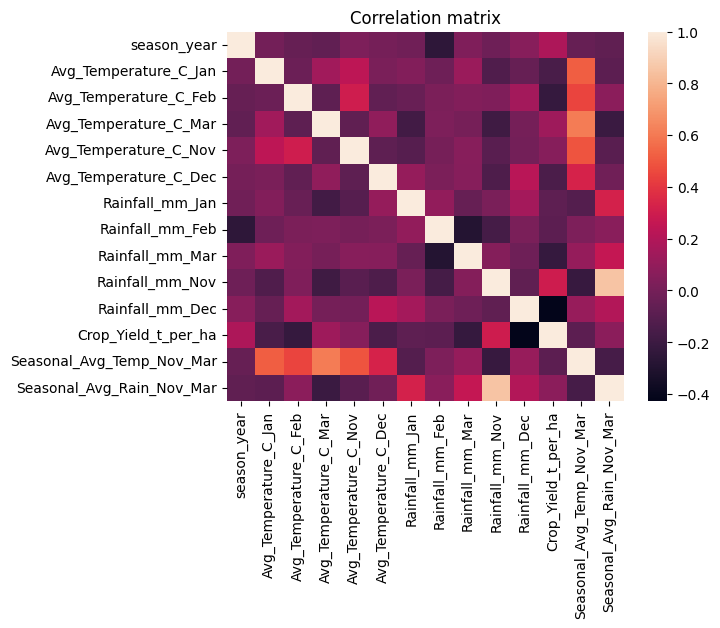

In [22]:
sns.heatmap(pivot_df_1.corr(numeric_only=True))
plt.title('Correlation matrix')

In [23]:
pivot_df_1

,District,season_year,Avg_Temperature_C_Jan,Avg_Temperature_C_Feb,Avg_Temperature_C_Mar,Avg_Temperature_C_Nov,Avg_Temperature_C_Dec,Rainfall_mm_Jan,Rainfall_mm_Feb,Rainfall_mm_Mar,Rainfall_mm_Nov,Rainfall_mm_Dec,Crop_Yield_t_per_ha,Seasonal_Avg_Temp_Nov_Mar,Seasonal_Avg_Rain_Nov_Mar
0,Ahmedabad,2019,15.61,20.39,31.60,20.95,17.325,24.45,13.90,20.15,137.88,29.530,NaN,21.175,45.182
1,Ahmedabad,2020,16.87,21.08,38.18,22.57,16.900,21.85,40.06,32.08,44.00,45.580,NaN,23.120,36.714
2,Ahmedabad,2021,21.03,15.95,35.66,23.26,17.830,26.31,38.54,25.82,112.05,18.780,2.74,22.746,44.300
3,Ahmedabad,2022,15.78,18.41,23.39,23.39,17.620,19.48,16.22,18.39,147.04,33.900,NaN,19.718,47.006
4,Ahmedabad,2023,18.20,14.47,32.74,21.97,16.950,8.69,9.73,20.87,101.85,19.860,3.62,20.866,32.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Trivandrum,2019,17.09,18.65,33.87,23.34,16.955,34.52,23.00,8.61,118.10,17.225,NaN,21.981,40.291
96,Trivandrum,2020,18.08,19.48,31.31,25.35,16.910,9.98,14.87,10.06,117.75,18.370,NaN,22.226,34.206
97,Trivandrum,2021,18.20,15.52,32.49,23.59,17.290,35.49,5.32,20.51,80.50,14.260,4.19,21.418,31.216
98,Trivandrum,2022,18.68,18.79,32.98,24.01,16.680,10.06,34.13,16.30,51.21,14.020,NaN,22.228,25.144


# Approach 2 - Considering all the months

In [24]:
filtered_df_2 = df.copy()

In [26]:
def fill_annual_yield_2(group):
    march_value = group.loc[group['Month'] == 'Mar', 'Crop_Yield_t_per_ha']
    if not march_value.empty:
        group['Crop_Yield_t_per_ha'] = march_value.values[0]
    return group 

In [27]:
filtered_df_2 = filtered_df_2.groupby(['District', 'Year'], group_keys=False).apply(fill_annual_yield_2).reset_index(drop=True)

C:\Users\Ganesh Valtule\AppData\Local\Temp\ipykernel_30824\3724327954.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df_2 = filtered_df_2.groupby(['District', 'Year'], group_keys=False).apply(fill_annual_yield_2).reset_index(drop=True)
C:\Users\Ganesh Valtule\AppData\Local\Temp\ipykernel_30824\3724327954.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df_2 = filtered_df_2.groupby(['District', 'Year'], group_keys=False).apply(fill_annual_yield_2).reset_index(drop=True)


In [28]:
pivot_df_2 = filtered_df_2.pivot_table(index=['District', 'Year'],columns='Month',values=['Avg_Temperature_C', 'Rainfall_mm'],aggfunc='mean').reset_index() 
pivot_df_2.columns = ['_'.join(col).strip() if isinstance(col, tuple) and col[1] != '' else col[0] for col in pivot_df_2.columns.values]

C:\Users\Ganesh Valtule\AppData\Local\Temp\ipykernel_30824\834364546.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df_2 = filtered_df_2.pivot_table(index=['District', 'Year'],columns='Month',values=['Avg_Temperature_C', 'Rainfall_mm'],aggfunc='mean').reset_index()


In [29]:
yield_df_2 = filtered_df_2.groupby(['District', 'Year'], as_index=False)['Crop_Yield_t_per_ha'].first()
pivot_df_2 = pivot_df_2.merge(yield_df_2, on=['District', 'Year'], how='left')

C:\Users\Ganesh Valtule\AppData\Local\Temp\ipykernel_30824\4182683627.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yield_df_2 = filtered_df_2.groupby(['District', 'Year'], as_index=False)['Crop_Yield_t_per_ha'].first()


In [30]:
pivot_df_2

,District,Year,Avg_Temperature_C_Jan,Avg_Temperature_C_Feb,Avg_Temperature_C_Mar,Avg_Temperature_C_Apr,Avg_Temperature_C_May,Avg_Temperature_C_Jun,Avg_Temperature_C_Jul,Avg_Temperature_C_Aug,...,Rainfall_mm_Apr,Rainfall_mm_May,Rainfall_mm_Jun,Rainfall_mm_Jul,Rainfall_mm_Aug,Rainfall_mm_Sep,Rainfall_mm_Oct,Rainfall_mm_Nov,Rainfall_mm_Dec,Crop_Yield_t_per_ha
0,Ahmedabad,2019,15.61,20.39,31.60,29.65,31.64,26.23,29.44,31.45,...,26.48,24.20,258.13,261.36,260.02,326.63,47.18,137.88,45.58,NaN
1,Ahmedabad,2020,16.87,21.08,38.18,35.07,34.34,26.36,27.66,29.39,...,25.93,14.49,279.83,257.34,327.77,353.88,94.19,44.00,18.78,NaN
2,Ahmedabad,2021,21.03,15.95,35.66,35.44,35.60,25.49,25.18,26.94,...,16.96,0.63,297.43,221.28,318.57,288.51,94.15,112.05,33.90,2.74
3,Ahmedabad,2022,15.78,18.41,23.39,34.70,33.06,28.79,28.71,26.05,...,27.78,9.02,251.33,286.08,235.38,268.94,72.32,147.04,19.86,NaN
4,Ahmedabad,2023,18.20,14.47,32.74,27.31,34.38,28.59,28.93,24.77,...,14.71,7.46,212.17,278.22,338.24,239.49,134.46,101.85,26.93,3.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Trivandrum,2019,17.09,18.65,33.87,35.12,34.01,24.89,28.75,26.26,...,19.24,9.28,320.89,234.90,336.27,362.13,119.15,118.10,18.37,NaN
96,Trivandrum,2020,18.08,19.48,31.31,24.31,39.24,27.96,28.04,25.64,...,18.09,27.85,266.86,307.36,335.72,315.91,100.59,117.75,14.26,NaN
97,Trivandrum,2021,18.20,15.52,32.49,34.01,25.18,27.21,26.51,31.34,...,26.77,10.64,271.02,240.15,274.62,277.94,101.55,80.50,14.02,4.19
98,Trivandrum,2022,18.68,18.79,32.98,28.11,28.49,29.28,27.47,28.66,...,35.78,28.49,268.16,188.21,311.00,272.21,117.54,51.21,22.25,NaN


# Inputation of Crop yield values 

### function for KNN imputation

In [31]:
def knn_inputation(pivot_df):
    df_knn = pivot_df.copy()
    num_cols = df_knn.select_dtypes(include='number').columns
    cols_to_impute = num_cols.drop(['season_year', 'Year'], errors='ignore')
    imputer = KNNImputer(n_neighbors=3)
    df_knn[cols_to_impute] = imputer.fit_transform(df_knn[cols_to_impute])
    return df_knn

### function for Regression imputation

In [32]:
def regression_inputation(pivot_df):
    df_reg = pivot_df.copy()

    train_df = df_reg[df_reg["Crop_Yield_t_per_ha"].notna()]
    test_df = df_reg[df_reg["Crop_Yield_t_per_ha"].isna()]

    features = [col for col in df_reg.columns if col not in ['District', 'Crop_Yield_t_per_ha', 'Year', 'season_year']]

    X_train = train_df[features]
    y_train = train_df["Crop_Yield_t_per_ha"]
    X_test = test_df[features]

    reg = LinearRegression()

    reg.fit(X_train, y_train)
    df_reg.loc[df_reg["Crop_Yield_t_per_ha"].isna(), "Crop_Yield_t_per_ha"] = reg.predict(X_test)
    return df_reg

In [ ]:


dataframes = {
    "approach_1": pivot_df_1,
    "approach_2": pivot_df_2
}

imputation_functions = {
    "knn_imputation": knn_inputation,
    "regression_imputation": regression_inputation
}

base_folder = "data"

for approach_name, df in dataframes.items():
    approach_folder = os.path.join(base_folder, approach_name)
    os.makedirs(approach_folder, exist_ok=True)
    
    for impute_name, impute_func in imputation_functions.items():
        
        df_imputed = impute_func(df.copy())
        
        file_path = os.path.join(approach_folder, f"{impute_name}.csv")
        df_imputed.to_csv(file_path, index=False)
        print(f"Saved {file_path}")

Saved data\approach_1\knn_imputation.csv
Saved data\approach_1\regression_imputation.csv
Saved data\approach_2\knn_imputation.csv
Saved data\approach_2\regression_imputation.csv
